# モデルの学習

In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import time

In [2]:
DATAPATH = "../../../data/DBLP/made/"
OUTPUTPATH = "../../../result/aminer/"

In [3]:
with open(DATAPATH + "keywords_delete_similar_words.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(2275, '3d imaging')

In [4]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import lightgbm as lgb #LightGBM
from sklearn.metrics import mean_squared_error
from sklearn import utils

from scipy.stats import pearsonr

In [5]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2275, 2275, 23), (2275, 2275), (2275, 2275, 23), (2275, 2275))

In [6]:
N = train_x.shape[0]
M = train_x.shape[1]
N, M

(2275, 2275)

In [7]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2586675, 23), (2586675,), (2586675, 23), (2586675,))

In [8]:
P = train_x.shape[0]
P

2586675

In [9]:
model = lgb.LGBMRegressor()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))


フィッティング時間: 3.4628960490226746
スコア時間: 0.9659537076950073


In [10]:
result_detail = model.predict(test_x)

In [11]:
result = model.predict(test_x)
result_before = model.predict(train_x)
result.shape, result_before.shape

((2586675,), (2586675,))

In [12]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 8.321, MSE: 69.231, 相関係数: 0.902


In [13]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 5.743, MSE: 32.978, 相関係数: 0.554


In [14]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=False)
df["実測順位"] = df["実測"].rank(ascending=False)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.21

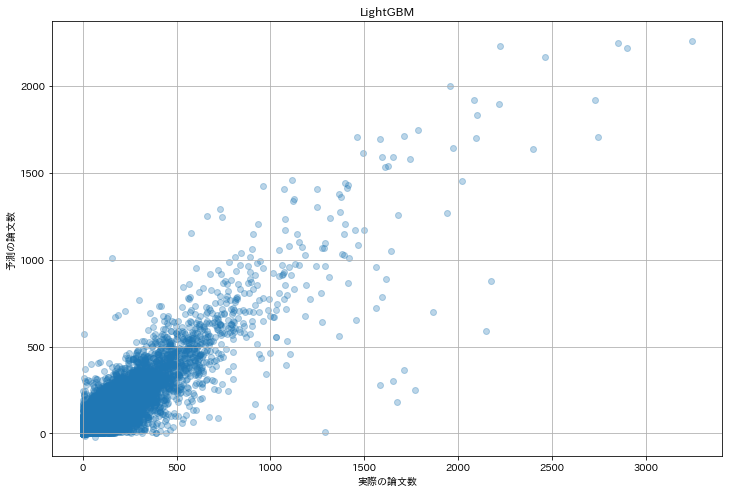

In [15]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

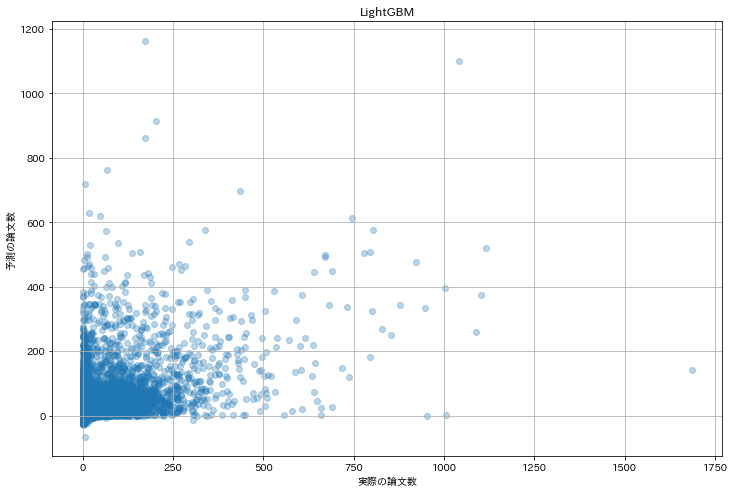

In [16]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [17]:
predict_matrix = np.zeros([N,N]) 
correct_matrix = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
predict_matrix[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if predict_matrix[i][j] > 400:
            print("キーワード: {}, {}, 予測値: {}, 実測値: {}".format(keywords[i], keywords[j],round(predict_matrix[i][j],1), correct_matrix[i][j]))

キーワード: accuracy, feature extraction, 予測値: 413.8, 実測値: 24.0
キーワード: algorithm, bioinformatics, 予測値: 464.0, 実測値: 13.0
キーワード: algorithm, design, 予測値: 1161.7, 実測値: 171.0
キーワード: algorithm, experimentation, 予測値: 762.2, 実測値: 68.0
キーワード: algorithm, performance, 予測値: 914.7, 実測値: 203.0
キーワード: algorithm, theory, 予測値: 458.6, 実測値: 70.0
キーワード: bioinformatics, biomedical research, 予測値: 717.5, 実測値: 6.0
キーワード: bioinformatics, genomics, 予測値: 463.9, 実測値: 283.0
キーワード: capacitors, switches, 予測値: 500.1, 実測値: 669.0
キーワード: cloud computing, servers, 予測値: 574.6, 実測値: 803.0
キーワード: cloud computing, virtualisation, 予測値: 452.7, 実測値: 271.0
キーワード: cognitive radio, cognitive radio networks, 予測値: 493.0, 実測値: 11.0
キーワード: cryptography, encryption, 予測値: 492.3, 実測値: 62.0
キーワード: database, face, 予測値: 535.1, 実測値: 96.0
キーワード: decoding, encoding, 予測値: 491.7, 実測値: 670.0
キーワード: design, experimentation, 予測値: 618.6, 実測値: 48.0
キーワード: design, human factors, 予測値: 529.4, 実測値: 20.0
キーワード: design, performance, 予測値: 862.5, 実測値: 173.0
キーワード

In [18]:
bool_matrix = np.zeros([N,N]) 
bool_matrix[np.triu_indices(n=N, k=1)] = train_y
word_matrix = np.zeros([N,N,2]).astype(str)
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
correct_new = correct_matrix[np.where(bool_matrix==0)]
predict_new = predict_matrix[np.where(bool_matrix==0)]
word_new = word_matrix[np.where(bool_matrix==0)]

In [19]:
df = pd.DataFrame(correct_new, columns=["実測値"])
df["予測値"] = predict_new
df["キーワード1"] = word_new[:,0]
df["キーワード2"] = word_new[:,1]
df.sort_values("予測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
792512,0.0,14.696215,different level,probability
416565,0.0,14.245673,col,robustness
1892026,0.0,14.245673,linear time,probability
1690975,0.0,14.070235,integrable system,robustness
2542071,0.0,14.070235,packaging,probability
1482687,0.0,14.070235,high performance,probability
1164448,0.0,14.070235,feedback loop,probability
1771909,0.0,12.805916,iteration method,testing
3754188,0.0,12.805916,telephony,testing
960598,0.0,12.805916,efficient method,testing


In [20]:
df.sort_values("実測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
3703880,953.0,0.279592,task analysis,training
1740315,224.0,0.287015,internet of things,task analysis
744974,168.0,0.550582,deconvolution,task analysis
741952,154.0,0.894369,decoding,task analysis
459010,149.0,0.449362,complexity theory,mimo communication
2163214,144.0,0.225698,mobile handsets,task analysis
77476,115.0,0.331875,analytical models,task analysis
3035679,110.0,0.742987,remote sensing,task analysis
3538568,104.0,0.225698,standards,task analysis
459545,98.0,0.225698,complexity theory,task analysis


# 人気度

In [21]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y_diff.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y_diff.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2275, 2275, 23), (2275, 2275), (2275, 2275, 23), (2275, 2275))

In [22]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2586675, 23), (2586675,), (2586675, 23), (2586675,))

In [23]:
model = lgb.LGBMRegressor()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))
result = model.predict(test_x)
result_before = model.predict(train_x)

フィッティング時間: 3.4776717610657215
スコア時間: 0.9914620406925678


In [24]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 8.662, MSE: 75.038, 相関係数: 0.855


In [25]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 7.347, MSE: 53.976, 相関係数: 0.906


In [26]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=True)
df["実測順位"] = df["実測"].rank(ascending=True)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.7

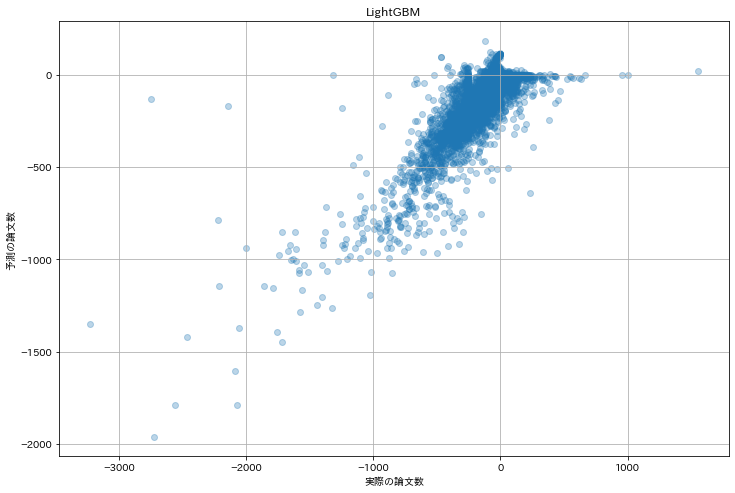

In [27]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
fig.savefig(OUTPUTPATH+"img/gbm_diff.png")
fig.show()

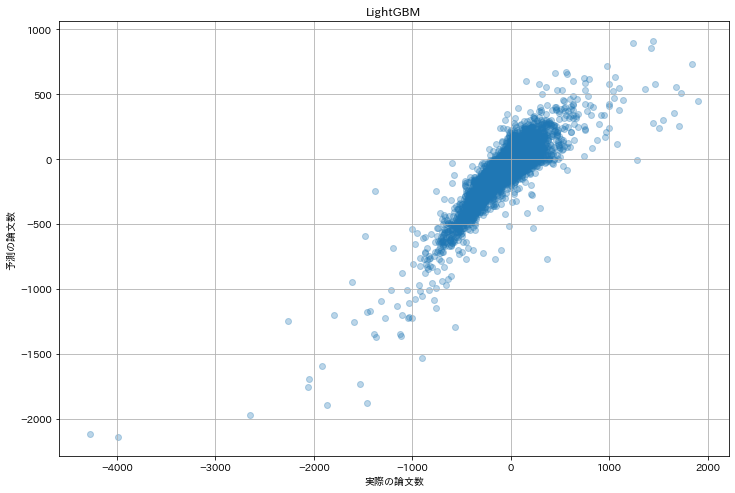

In [28]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [29]:
predict_matrix = np.zeros([N,N]) 
correct_matrix = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
predict_matrix[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if predict_matrix[i][j] < -2000:
            print("キーワード: {}, {}, 予測値: {}, 実測値: {}".format(keywords[i], keywords[j],round(predict_matrix[i][j],1), correct_matrix[i][j]))

In [30]:
predict_matrix = np.zeros([N,N]) 
correct_matrix = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
predict_matrix[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if predict_matrix[i][j] < -2000:
            print("キーワード: {}, {}, 予測値: {}, 実測値: {}".format(keywords[i], keywords[j],round(predict_matrix[i][j],1), correct_matrix[i][j]))

In [31]:
correct_new = correct_matrix[np.where(bool_matrix==0)]
predict_new = predict_matrix[np.where(bool_matrix==0)]
word_new = word_matrix[np.where(bool_matrix==0)]

In [32]:
df = pd.DataFrame(correct_new, columns=["実測値"])
df["予測値"] = predict_new
df["キーワード1"] = word_new[:,0]
df["キーワード2"] = word_new[:,1]
df.sort_values("予測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
1758463,0.0,12.001603,inventory,planar graph
1758361,0.0,12.001603,inventory,numerical solution
312652,0.0,10.346615,capacitors,distributed algorithm
238036,0.0,10.346615,biomedical mri,distributed algorithm
290679,0.0,10.252711,business model,distributed algorithm
230413,0.0,10.252711,biomechanics,distributed algorithm
595392,0.0,10.252711,convolutional code,distributed algorithm
166384,0.0,10.084372,awgn,distributed algorithm
292320,0.0,10.084372,business process,distributed algorithm
471541,0.0,10.030572,computational biology,distributed algorithm


In [33]:
df.sort_values("実測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
3703880,953.0,0.173015,task analysis,training
1740315,224.0,0.173015,internet of things,task analysis
744974,168.0,0.227680,deconvolution,task analysis
741952,154.0,-0.146371,decoding,task analysis
459010,149.0,0.219943,complexity theory,mimo communication
2163214,144.0,0.077555,mobile handsets,task analysis
77476,115.0,-0.016349,analytical models,task analysis
3035679,110.0,0.079977,remote sensing,task analysis
3538568,104.0,0.173015,standards,task analysis
459545,98.0,0.168970,complexity theory,task analysis
